# 1.Preparation
---

## enviroments

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf


## collection data

In [2]:
import urllib.request

# Set source URL

url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

In [3]:
# Determine current directory
pwd = os.getcwd()

# Determine dataset directory which will be created
dataset_dir = os.path.join(pwd, 'dataset')
dataset_dir

'c:\\Users\\redoa\\workspace\\projects\\first_vae\\dataset'

In [6]:
# Creation of dataset directory and check the contents
os.makedirs(dataset_dir, exist_ok=True)
contents = os.listdir('./dataset')
print(contents) # this will show the empty list [] for the first time


['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz']


In [5]:
# Download the dataset from source, and check the contents are downloaded
for v in key_file.values():
    file_path = os.path.join(dataset_dir, v)
    if not os.path.exists(file_path):
        urllib.request.urlretrieve(url_base + v, file_path)
        
print(contents)


['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz']


 ## Data transformation

In [10]:
# To unzip gz file, use gzip('file name', 'mode e.g. r, w, rb,....')
# rb mode to load the binary file
# To open files, use open() with with statement to open and close the file. Evenif the error occurs, the file will be closed safely.

import gzip

def data_preload_test(file_name):
    """Function to load the data temporarily and check the length of the data."""
    file_path = dataset_dir + '/' + key_file[file_name]
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8)
    return len(data)


In [16]:
# Testing with train image file and label

print('train data :',data_preload_test('train_img'),'\n','train label :', data_preload_test('train_label'))

train data : 47040016 
 train label : 60008


data length that we saw must be multiple of mnist image size which is 28*28. Same for label but it is 10 (total class). Let's check it

In [22]:
# train data : 47040016
print('Extra data for train data: ',(47040016)%(28**2))

# train label : 60008
print('Extra data for train label :',(60008)%(10))

Extra data for train data:  16
Extra data for train label : 8


There are 16 extra data for train image data and 8 extra data for train label data that we do not need. to exclude its, use offset argument.

In [30]:
def load_image(file_name):
    file_path = os.path.join(dataset_dir, key_file[file_name])
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 784)
    return data

def load_label(file_name):
    file_path = os.path.join(dataset_dir, key_file[file_name])
    with gzip.open(file_path, 'rb') as f:
        label = np.frombuffer(f.read(), np.uint8, offset=8)
    return label

In [32]:
# Decline the dataset and load data

dataset = {}
dataset['train_img'] = load_image('train_img')
dataset['train_label'] = load_label('train_label')
dataset['test_img'] = load_image('test_img')
dataset['test_label'] = load_label('test_label')


In [37]:
import pickle

save_file = dataset_dir + '/mnist.pkl'  
with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)

In [39]:
# load dataset from the saved file
with open(save_file, 'rb') as f:
    dataset = pickle.load(f)


In [41]:
print(dataset['train_img'].shape)   
print(dataset['train_label'].shape)   


(60000, 784)
(60000,)


Datasets are loaded correctly. Take a look example Image.

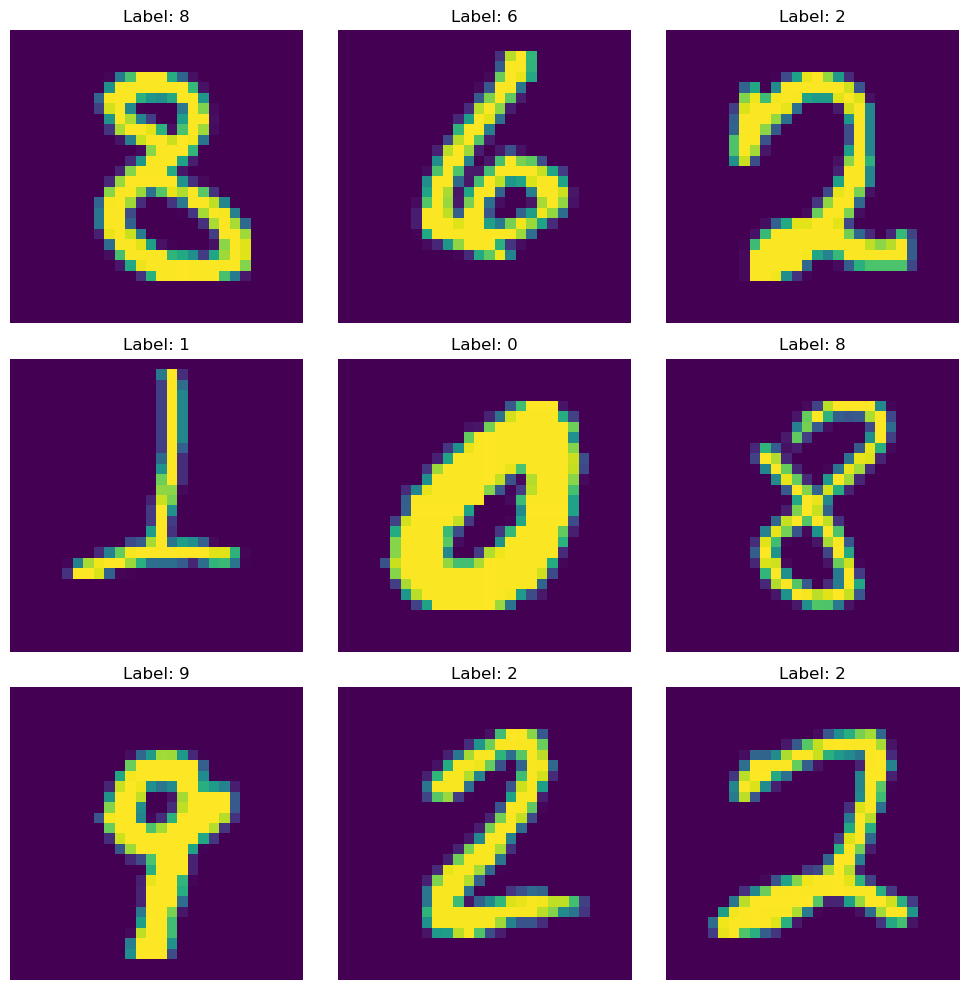

In [47]:
import random
# Select nine random indices
random_indices = random.sample(range(len(dataset['train_img'])), 9)

# Create a subplot with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over the random indices and plot the images with labels
for i, index in enumerate(random_indices):
    img = dataset['train_img'][index].reshape((28, 28))
    label = dataset['train_label'][index]
    
    # Plot the image
    axes[i // 3, i % 3].imshow(img)
    axes[i // 3, i % 3].axis('off')
    
    # Set the label as the title of the subplot
    axes[i // 3, i % 3].set_title('Label: {}'.format(label.argmax()))

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


It shows that label dataset contains label number directly. Let's combine to one-hot label for ML model.

In [44]:
def to_one_hot(label):
    T = np.zeros((label.size, 10))
    for i in range(label.size):
        T[i][label[i]] = 1
    return T

dataset['train_label'] = to_one_hot(dataset['train_label'])
dataset['train_label'].shape    #-> (60000, 10)


(60000, 10)

And normalyze.

In [45]:
def normalize(key):
    dataset[key] = dataset[key].astype(np.float16)
    dataset[key] /= 255.

    return dataset[key]

dataset['train_img'] = normalize('train_img')


In [49]:
# Prepare the validation set

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(dataset['train_img'], dataset['train_label'], test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(48000, 784) (48000, 10)
(12000, 784) (12000, 10)


In [50]:
# Processing the test set
dataset['test_img'] = normalize('test_img')
dataset['test_label'] = to_one_hot(dataset['test_label'])
dataset['test_label'].shape    #-> (10000, 10)

(10000, 10)

# Construction Model

In [52]:
# Importing the necessary libraries for the model

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


First model will be simple VAE model which has encoder and decoder layer, 2 dimention z layer with Reparametrization Trick.\
If a certain number is input and narrowed down to 64 dimensions, the mean and variance are examined, and it is determined to which normal distribution the number belongs.\
A value randomly sampled from this distribution is placed into Z, and the weights of the decoder are learned so that there is no difference between the input and output.\
 This way, it seems possible to distribute the numbers 0 to 9 without overlapping effectively.\
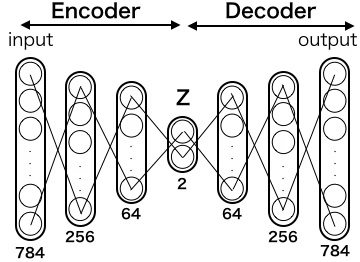

However, there is a problem with this approach: introducing random sampling elements prevents backpropagation of errors.\
To overcome this while retaining the concept, the Reparametrization Trick was developed. \
This technique allows for error backpropagation to be possible even with the inclusion of random sampling elements.

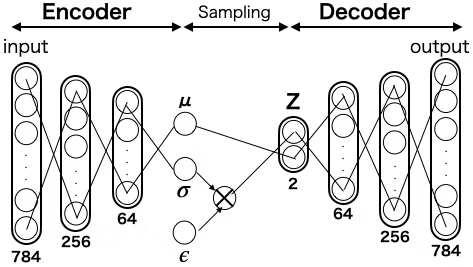\
Ref: https://qiita.com/jun40vn/items/374763f478ee094c5041

In [57]:
# Determine cofiguration of the model
class Config:
    input_dim = X_train.shape[1] # 784
    latent_dim = 2
    batch_size = 256
    epochs = 100
    learning_rate = 0.001

config = Config()

In [58]:
# Encoder layer
"""
Blue print to build vae encoder -> :
1. Define Inputs
2. x for detail of Dense layer
3. z layer's logvar and mean
4. and Combine them to the model.  
"""

def build_encoder(config):
    inputs = Input(shape=(config.input_dim,))
    x = Dense(config.latent_dim, activation=)(inputs)

In [68]:
encoder = encoder(config)

In [59]:
# Decoder layer
# decoder = Sequential([Dense(X.shape[1], activation='sigmoid', input_shape=[latent_dim])])

def decoder(config):
    model = Sequential([
        Dense(config.input_dim, activation='sigmoid', input_shape=(config.latent_dim,))
    ])
    return model

In [69]:
decoder = decoder(config)

In [70]:
# Z layer + sampling layer (reparameterization trick)

def sampling_layer(config):
    def sample(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), seed=42)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    return Lambda(sample)

In [71]:
# VAE model construction

def VAE(config):
    enc = encoder(config)
    dec = decoder(config)
    z = sampling_layer(config)
    vae = Sequential([enc, z, dec])
    return vae

vae = VAE(config)


TypeError: Inputs to a layer should be tensors. Got: <__main__.Config object at 0x000001F45FC0ADC0>

For VAE model, we use specific loss function which called KL loss.
$$
L = E_{z \sim q(z|x)}log_{Pmodel}(x|z)-D_{KL}(q(z|x)||Pmodel(z))
$$\
The first term represents the expected log-likelihood of the data X with respect to q(z|X), indicating how close the output is to the original data, so it is replaced with the squared error.\
The second term is known as the Kullback-Leibler divergence (KL represents KL divergence), and when p(z) is assumed to be a normal distribution,
$$
=\beta||y-x||^2 - D_{KL}

(N(\mu, \sigma)|N(0,1))\
$$\
The second term is expressed as kl_loss, with sigma=z_logvar, mu=z_mean, and when further replaced with an approximation formula, the loss function L(vae_loss) becomes as follows:

In [62]:
from tensorflow.keras.losses import binary_crossentropy

def vae_loss(x, x_decoded_mean, sampling, z_log_var, z_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [65]:
def sampling(config):
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), seed=42)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    return sampling


TypeError: To be compatible with tf.function, Python functions must return zero or more Tensors or ExtensionTypes or None values; in compilation of <function sampling at 0x000001F4254DB4C0>, found return value of type Lambda, which is not a Tensor or ExtensionType.